In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from my_script import utils
import importlib
import os
import numpy as np
plt.rcParams["axes.titlesize"] = 25
plt.rcParams["axes.labelsize"] = 25
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["lines.markersize"] = 5
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['legend.title_fontsize'] = 15
plt.rcParams['legend.edgecolor'] = 'dimgray'

In [2]:
deepsea_df = df = pd.read_csv("/project/cphg-millerlab/CAD_QTL/coronary_QTL/epigenome/scATAC/deepsea/CAD_diffs.tsv", sep='\t')
BPNet_df = pd.read_csv("/project/cphg-millerlab/CAD_QTL/coronary_QTL/epigenome/scATAC/BPNet/avg_results.tsv", sep='\t')

In [3]:
cell_types = """
Plasma
Macrophage
T
Mast
Endothelial
Pericyte
SMC
Fibroblast
unknown
""".strip().split()

In [4]:
deepsea_color = "#cd5555" # 205,85,85
BPNet_color = "#36648b" # 54,100,139
deepsea_palette = sns.color_palette("Oranges", as_cmap=True)
BPNet_palette = sns.color_palette("Blues", as_cmap=True)
deepsea_palette_extended = sns.diverging_palette(220, 20, as_cmap=True)
BPNet_palette_extended = sns.diverging_palette(145, 300, s=60, as_cmap=True)
cell_type_palette = {cell_type:sns.color_palette("husl", 9)[i] for i,cell_type in enumerate(cell_types)}

# Figure 2: Metrics

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

In [203]:
test_predictions = np.load("/scratch/dyl3pc/Clint/selene_scATAC_MCAS2_saved_dataset/models/test/test_predictions.npz")['data']
test_targets = np.load("/scratch/dyl3pc/Clint/selene_scATAC_MCAS2_saved_dataset/models/test/test_targets.npz")['data']

<ipython-input-210-c54abc251860>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'r-', color=cell_type_palette[feature], alpha=0.8, lw=1)
<ipython-input-210-c54abc251860>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'r-', color=cell_type_palette[feature], alpha=0.8, lw=1)
<ipython-input-210-c54abc251860>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'r-', color=cell_type_palette[feature], alpha=0.8, lw=1)
<ipython-input-210-c54abc251860>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take preced

Text(0, 0.5, 'True Positive Rate')

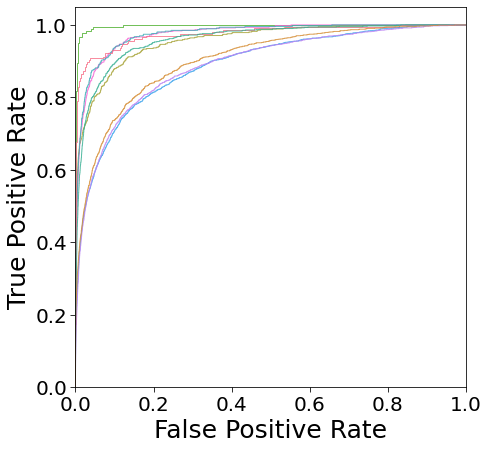

In [210]:
with open("/scratch/dyl3pc/Clint/MACS2_data/features.txt") as f:
    feature_order = f.read().strip().split()

for i, feature in enumerate(feature_order):
    feature_targets = test_targets[:,i]
    feature_preds = test_predictions[:,i]
    fpr, tpr, _ = roc_curve(feature_targets, feature_preds)
    plt.plot(fpr, tpr, 'r-', color=cell_type_palette[feature], alpha=0.8, lw=1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

<ipython-input-213-2d3d0c1ad629>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.step(precision, recall, 'r-', color=cell_type_palette[feature], alpha=0.8, lw=1)
<ipython-input-213-2d3d0c1ad629>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.step(precision, recall, 'r-', color=cell_type_palette[feature], alpha=0.8, lw=1)
<ipython-input-213-2d3d0c1ad629>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.step(precision, recall, 'r-', color=cell_type_palette[feature], alpha=0.8, lw=1)
<ipython-input-213-2d3d0c1ad629>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keywor

Text(0, 0.5, 'Precision')

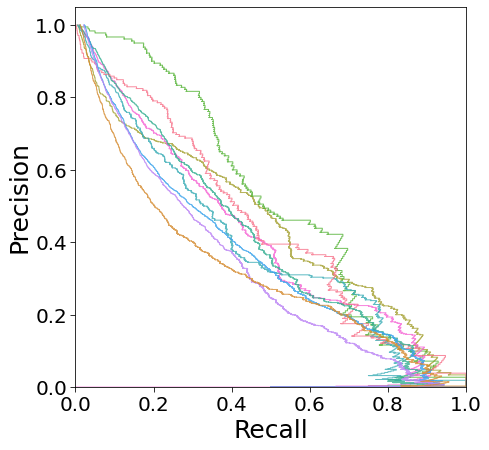

In [213]:
for i, feature in enumerate(feature_order):
    feature_targets = test_targets[:,i]
    feature_preds = test_predictions[:,i]
    precision, recall, _ = precision_recall_curve(feature_targets, feature_preds)
    plt.step(precision, recall, 'r-', color=cell_type_palette[feature], alpha=0.8, lw=1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')

In [188]:
test_predictions["data"].shape

(120000, 9)

In [189]:
test_targets["data"].shape

(120000, 9)

In [193]:
precision_recall_curve(test_predictions["data"].reshape(-1), test_targets["data"].reshape(-1))

ValueError: continuous format is not supported

# Figure 3: SMAD3 rediscovery

## Locuszoom

In [392]:
def make_locuszoom_plot_and_get_other_variants(putative_causal_snp):
    df = pd.read_csv("/scratch/dyl3pc/fastqtl/data/correct_GWAS_sumstats/gwas_catalog/CAD.tsv.gz", sep='\t')
    causal_snp_data = df[df['variant_id'] == putative_causal_snp].iloc[0]
    chr_ = causal_snp_data['CHR']
    pos = causal_snp_data['POS']
    locus_start = pos - 100000
    locus_end = pos + 100000
    df = df[(df['CHR'] == chr_) & (df['POS'] > locus_start) & (df['POS'] < locus_end)][['variant_id', 'P']]
    df.columns = ['rsid', 'P']
    df.to_csv("intermediate/locuszoom_pvals.tsv", sep='\t', index=False)
    utils.run_locuszoom("/scratch/dyl3pc/coronary_artery_scATAC/intermediate/locuszoom_pvals.tsv", "/scratch/dyl3pc/coronary_artery_scATAC/intermediate/locuszoom_plot.pdf",
                    "rsid", "P", "CAD_GWAS", putative_causal_snp)
    print(df.sort_values(["P"]).head(20))
    return df

In [393]:
df = make_locuszoom_plot_and_get_other_variants("rs17293632")


    module load goolf/7.1.0_3.1.4 R
    /apps/software/standard/mpi/gcc/7.1.0/openmpi/3.1.4/R/4.0.3/bin/Rscript /scratch/dyl3pc/.tools/my_scripts/my_script/locuszoom.R         --input /scratch/dyl3pc/coronary_artery_scATAC/intermediate/locuszoom_pvals.tsv         --output /scratch/dyl3pc/coronary_artery_scATAC/intermediate/locuszoom_plot.pdf         --SNP_col_name rsid         --pval_col_name P         --ylabel CAD_GWAS         --highlight_snp rs17293632
    
               rsid             P
1876670  rs72743461  5.676000e-17
1876702  rs17228058  6.379000e-17
1876676  rs17293632  7.692000e-17
1876719  rs56062135  8.557000e-17
1876696  rs56375023  9.225000e-17
1876746  rs72743477  2.834000e-14
1876756  rs72743482  7.966000e-14
1876707  rs72743467  2.759000e-12
1876728   rs4562997  2.378000e-11
1876678   rs8024330  3.275000e-11
1876695  rs28434383  3.319000e-11
1876673   rs1866316  7.583000e-11
1876698   rs8032739  8.735000e-11
1876714   rs7164786  9.230000e-11
1876713   rs9920190  9.97

## Barplots/Heatmaps

In [97]:
# SMAD3
causal_variant = 'rs17293632'
non_causal_variant = ['rs72743461', 'rs56375023', 'rs56062135', 'rs17228058']

In [98]:
def make_barplots_and_heatmaps_SMAD3(causal_variant, non_causal_variant):
    all_variants = [causal_variant] + non_causal_variant
    
    # barplot
    deepsea_causal_df = deepsea_df[deepsea_df['name'] == causal_variant]
    deepsea_causal_df = deepsea_causal_df[cell_types].T.reset_index()
    deepsea_causal_df.columns = ['Cell Type', 'DeepSEA Prediction Difference']

    plt.rcParams["figure.figsize"] = (10,6)
    ax = sns.barplot(x="Cell Type", y="DeepSEA Prediction Difference", data=deepsea_causal_df, color=deepsea_color)
    ax.set_ylabel("DeepSEA Diff ($Ref-ALT$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_title(causal_variant)
    plt.show()
    
    # heatmap
    deepsea_all_variants_df = deepsea_df[deepsea_df['name'].isin(all_variants)]
    deepsea_all_variants_df = deepsea_all_variants_df.set_index("name")[cell_types]
    ax = sns.heatmap(data=deepsea_all_variants_df, cmap = deepsea_palette)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel("")
    plt.show()
    cols_to_keep_lfc =  [f"{ctype}_fold_avg_lfc" for ctype in cell_types]
    
    # BPNet barplot
    BPNet_causal_df = BPNet_df[BPNet_df['rs'] == causal_variant][cols_to_keep_lfc]
    BPNet_causal_df.columns = cell_types
    BPNet_causal_df = BPNet_causal_df.T.reset_index()
    BPNet_causal_df.columns = ['Cell Type', 'logFC']

    ax = sns.barplot(x="Cell Type", y="logFC", data=BPNet_causal_df, color=BPNet_color)
    ax.set_ylabel("BPNet $log_2$(Fold Change)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_title(causal_variant)
    plt.show()
    
    # BPNet heatmap
    BPNet_all_variants_df = BPNet_df[BPNet_df['rs'].isin(all_variants)]
    BPNet_all_variants_df = BPNet_all_variants_df.set_index("rs")[cols_to_keep_lfc]
    BPNet_all_variants_df.columns = cell_types
    ax = sns.heatmap(data=BPNet_all_variants_df, cmap = BPNet_palette)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel("")
    plt.show()

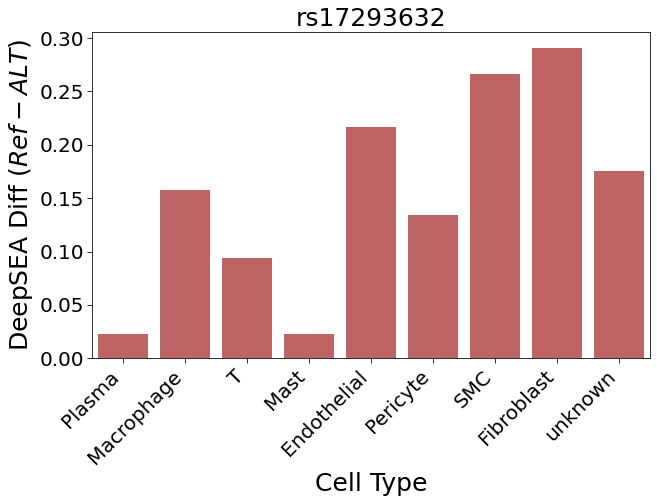

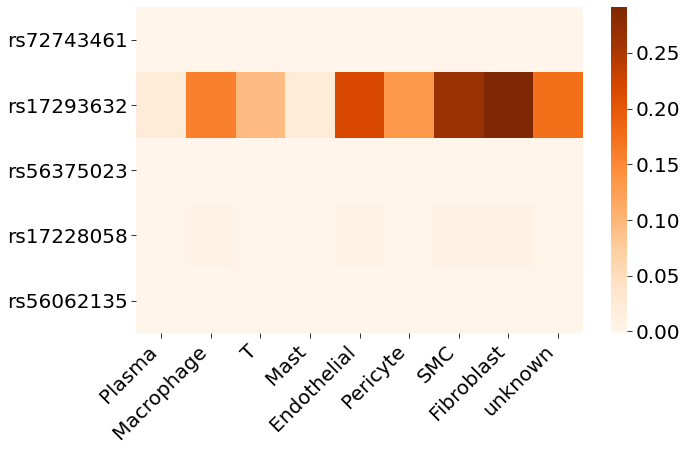

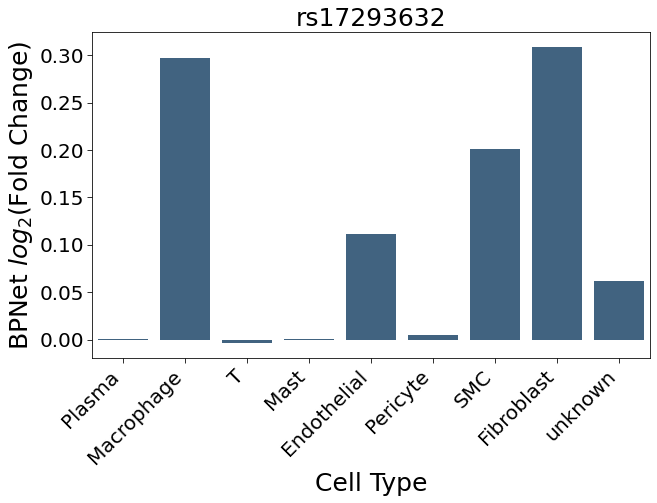

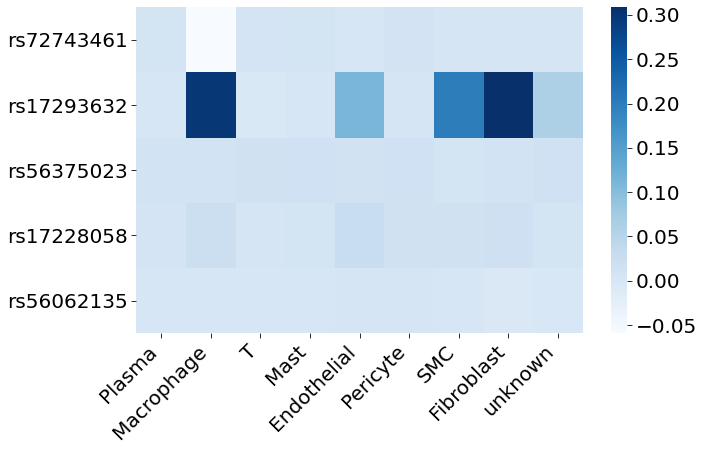

In [99]:
make_barplots_and_heatmaps_SMAD3(causal_variant, non_causal_variant)

# Figure 4: Comparing Model Scores

In [174]:
deepsea_scores_l = []
BPNet_scores_l = []
celltype_l = []
rsid_l = []
for rsid in deepsea_df['name']:
    deepsea_rsid_df = deepsea_df[deepsea_df['name'] == rsid]
    BPNet_rsid_df = BPNet_df[BPNet_df['rs'] == rsid]
    for ctype in cell_types:
        deepsea_scores_l.append(deepsea_rsid_df.iloc[0][ctype])
        BPNet_scores_l.append(BPNet_rsid_df.iloc[0][f'{ctype}_fold_avg_lfc'])
        celltype_l.append(ctype)
        rsid_l.append(rsid)

In [175]:
df = pd.DataFrame({'rsid':rsid_l, 'cell_type':celltype_l, 'deepsea_diff': deepsea_scores_l, 'BPNet_lfc': BPNet_scores_l})

(-0.65, 0.65)

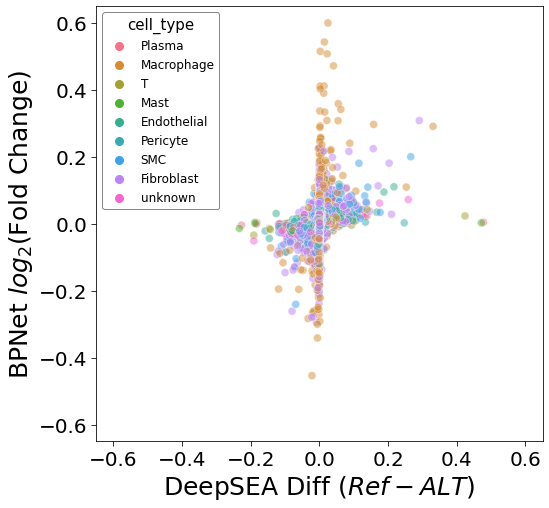

In [214]:
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.loc'] = "upper left"


sns.scatterplot(data=df, x="deepsea_diff", y="BPNet_lfc", alpha=0.5, hue="cell_type", palette=cell_type_palette)
plt.xlabel("DeepSEA Diff ($Ref-ALT$)")
# plt.ylabel("BPNet $log_2$(Fold Change)")
# # plt.plot([-0.3,-0.3], [-0.3, 0.3], 'k--', markeredgewidth=0.5, alpha=0.5)
# # plt.plot([-0.3, 0.3], [0.3, 0.3], 'k--', markeredgewidth=0.5, alpha=0.5)
# # plt.plot([0.3, 0.3], [0.3, -0.3], 'k--', markeredgewidth=0.5, alpha=0.5)
# # plt.plot([0.3, -0.3], [-0.3, -0.3], 'k--', markeredgewidth=0.5, alpha=0.5)
plt.xlim([-0.65, 0.65])
plt.ylim([-0.65, 0.65])

(-0.3, 0.3)

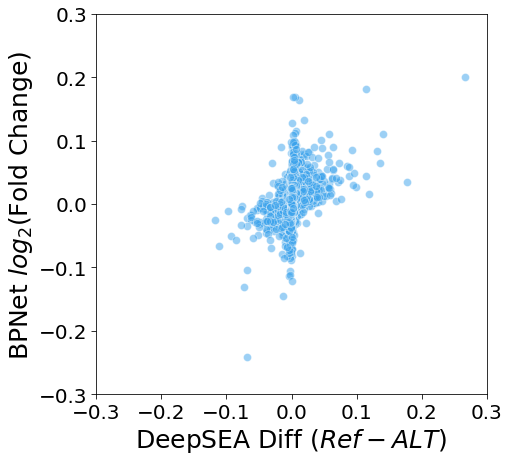

In [177]:
plt.rcParams["figure.figsize"] = (7,7)
plt.rcParams["lines.markersize"] = 8
data = df[df['cell_type']=="SMC"]
sns.scatterplot(data=data, x="deepsea_diff", y="BPNet_lfc", alpha=0.5, color=cell_type_palette['SMC'])
plt.xlabel("DeepSEA Diff ($Ref-ALT$)")
plt.ylabel("BPNet $log_2$(Fold Change)")
plt.xlim([-0.3, 0.3])
plt.ylim([-0.3, 0.3])

rs1958320
rs17293632
rs4887091
rs17374036
rs56155140


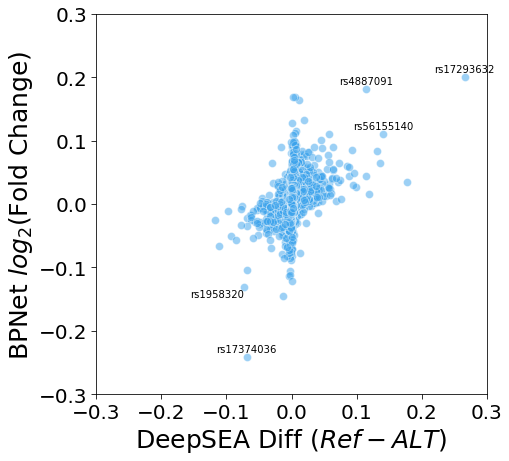

In [215]:
plt.rcParams["figure.figsize"] = (7,7)


data = df[df['cell_type']=="SMC"]
sns.scatterplot(data=data, x="deepsea_diff", y="BPNet_lfc", alpha=0.5, color=cell_type_palette['SMC'])
plt.xlabel("DeepSEA Diff ($Ref-ALT$)")
plt.ylabel("BPNet $log_2$(Fold Change)")
plt.xlim([-0.3, 0.3])
plt.ylim([-0.3, 0.3])

for x,y,label in zip(data['deepsea_diff'], data['BPNet_lfc'], data['rsid']):

    if abs(x)>=np.quantile(abs(data['deepsea_diff']), 0.997) and abs(y) >=np.quantile(abs(data['BPNet_lfc']), 0.997):
        offset = (0,5)
        ha = 'center'
        print(label)
        if label == 'rs1958320':
            ha = "right"
            offset = (0,-10)
        elif label == "rs56170783":
            offset = (0,-10)
        plt.annotate(label, # this is the text
                     (x,y), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=offset, # distance from text to points (x,y)
                     ha=ha) # horizontal alignment can be left, right or center

plt.show()

# Figure 5: New Causal Variants

In [133]:
potentially_relevant_snps = """
rs1958320
rs17293632
rs4887091
rs17374036
rs56155140
""".strip().split()

In [134]:
!mkdir ld_variants

mkdir: cannot create directory ‘ld_variants’: File exists


In [135]:
for causal_variant in potentially_relevant_snps:
    print(causal_variant)
    if not os.path.exists("ld_variants/{causal_variant}.tsv"):
        cmd = f"curl -k -X GET 'https://ldlink.nci.nih.gov/LDlinkRest/ldproxy?var={causal_variant}&pop=MXL&r2_d=r2&window=500000&genome_build=grch38&token=213b286dc9a5' > ld_variants/{causal_variant}.tsv"
        os.system(cmd)

rs1958320
rs17293632
rs4887091
rs17374036
rs56155140


In [136]:
def make_barplots_and_heatmaps(causal_variant, non_causal_variant):
    all_variants = [causal_variant] + non_causal_variant
    
    # barplot
    deepsea_causal_df = deepsea_df[deepsea_df['name'] == causal_variant]
    deepsea_causal_df = deepsea_causal_df[cell_types].T.reset_index()
    deepsea_causal_df.columns = ['Cell Type', 'DeepSEA Prediction Difference']

    plt.rcParams["figure.figsize"] = (10,6)
    ax = sns.barplot(x="Cell Type", y="DeepSEA Prediction Difference", data=deepsea_causal_df, color=deepsea_color)
    ax.set_ylabel("DeepSEA Diff ($Ref-ALT$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_title(causal_variant)
    plt.show()
    
    # heatmap
    plt.rcParams["figure.figsize"] = (10,0.5*len(all_variants))
    deepsea_all_variants_df = deepsea_df[deepsea_df['name'].isin(all_variants)]
    deepsea_all_variants_df = deepsea_all_variants_df.set_index("name")[cell_types]
    ax = sns.heatmap(data=deepsea_all_variants_df, cmap = deepsea_palette_extended, vmin=-0.2, vmax=0.2)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel("")
    plt.show()
    cols_to_keep_lfc =  [f"{ctype}_fold_avg_lfc" for ctype in cell_types]
    
    # BPNet barplot
    BPNet_causal_df = BPNet_df[BPNet_df['rs'] == causal_variant][cols_to_keep_lfc]
    BPNet_causal_df.columns = cell_types
    BPNet_causal_df = BPNet_causal_df.T.reset_index()
    BPNet_causal_df.columns = ['Cell Type', 'logFC']

    plt.rcParams["figure.figsize"] = (10,6)
    ax = sns.barplot(x="Cell Type", y="logFC", data=BPNet_causal_df, color=BPNet_color)
    ax.set_ylabel("BPNet $log_2$(Fold Change)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_title(causal_variant)
    plt.show()
    
    # BPNet heatmap
    plt.rcParams["figure.figsize"] = (10,0.5*len(all_variants))
    BPNet_all_variants_df = BPNet_df[BPNet_df['rs'].isin(all_variants)]
    BPNet_all_variants_df = BPNet_all_variants_df.set_index("rs")[cols_to_keep_lfc]
    BPNet_all_variants_df.columns = cell_types
    ax = sns.heatmap(data=BPNet_all_variants_df, cmap = BPNet_palette_extended, vmin=-0.2, vmax=0.2)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel("")
    plt.show()

################################################
####### Causal variant: rs1958320 ########
################################################


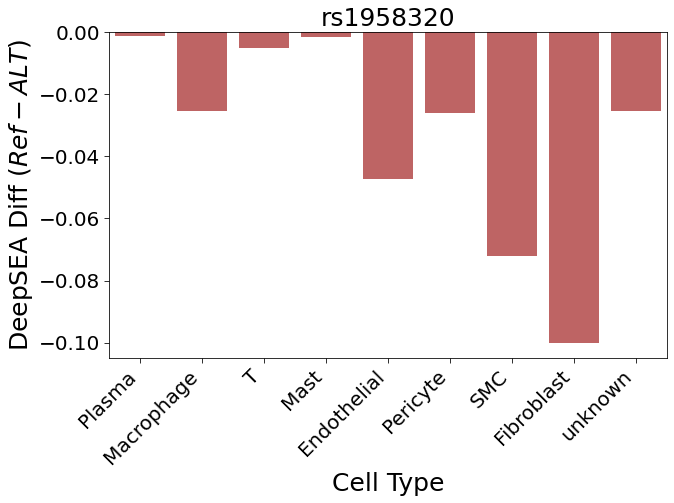

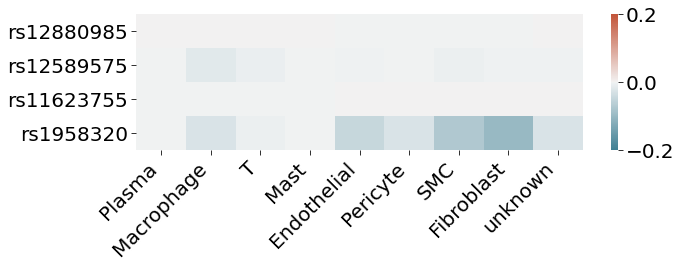

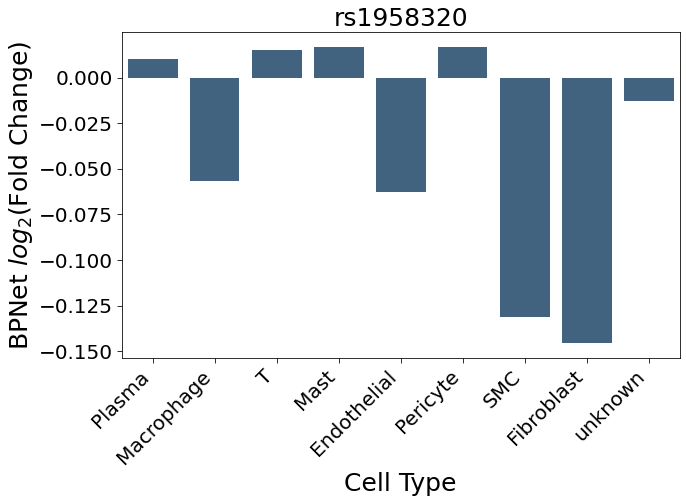

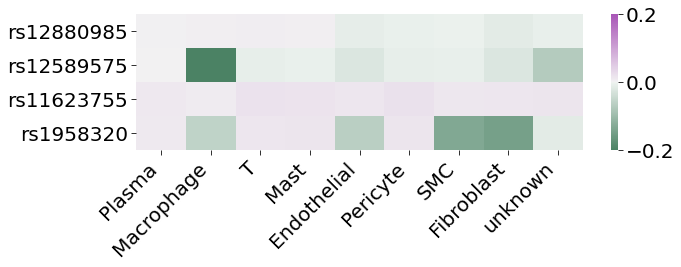

################################################
####### Causal variant: rs17293632 ########
################################################


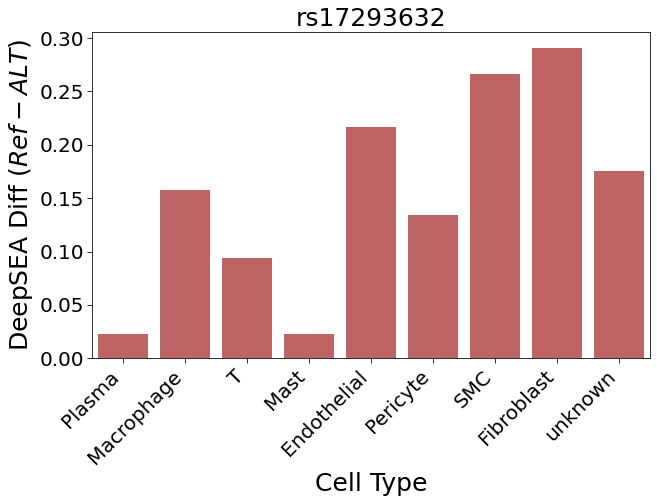

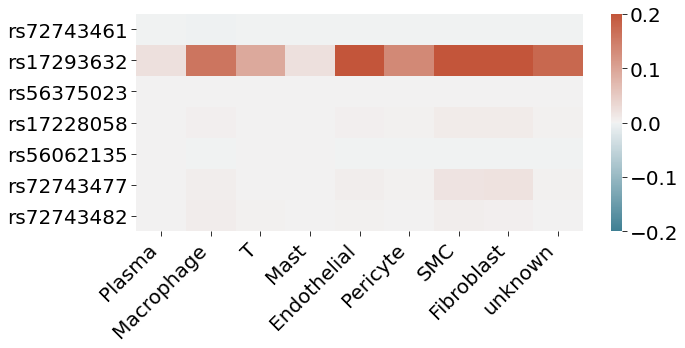

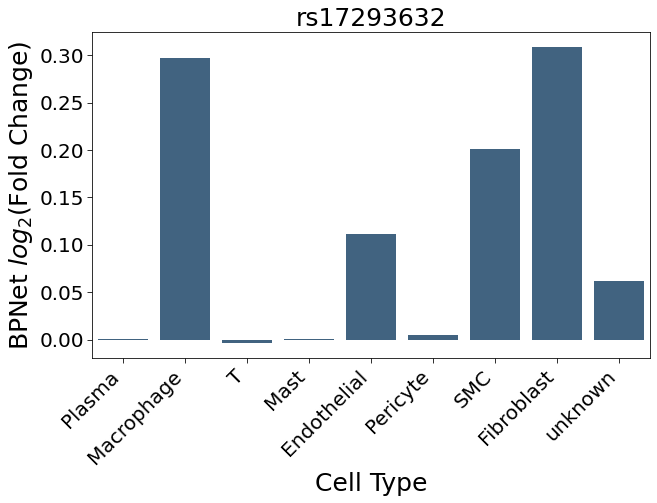

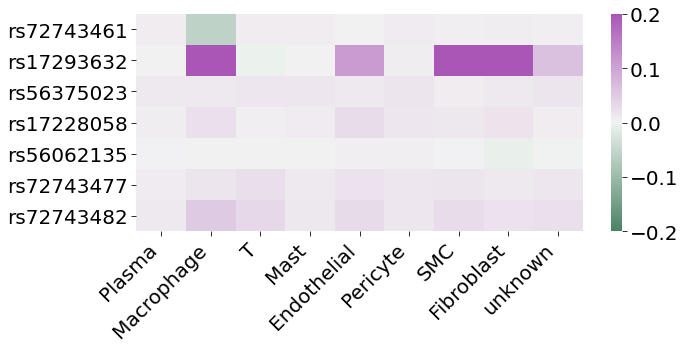

################################################
####### Causal variant: rs4887091 ########
################################################


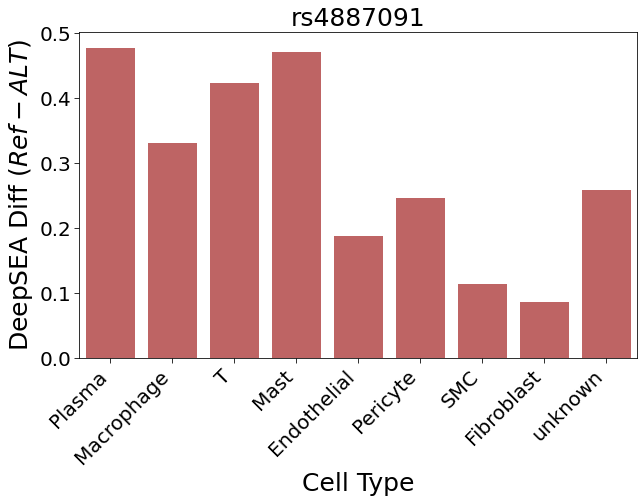

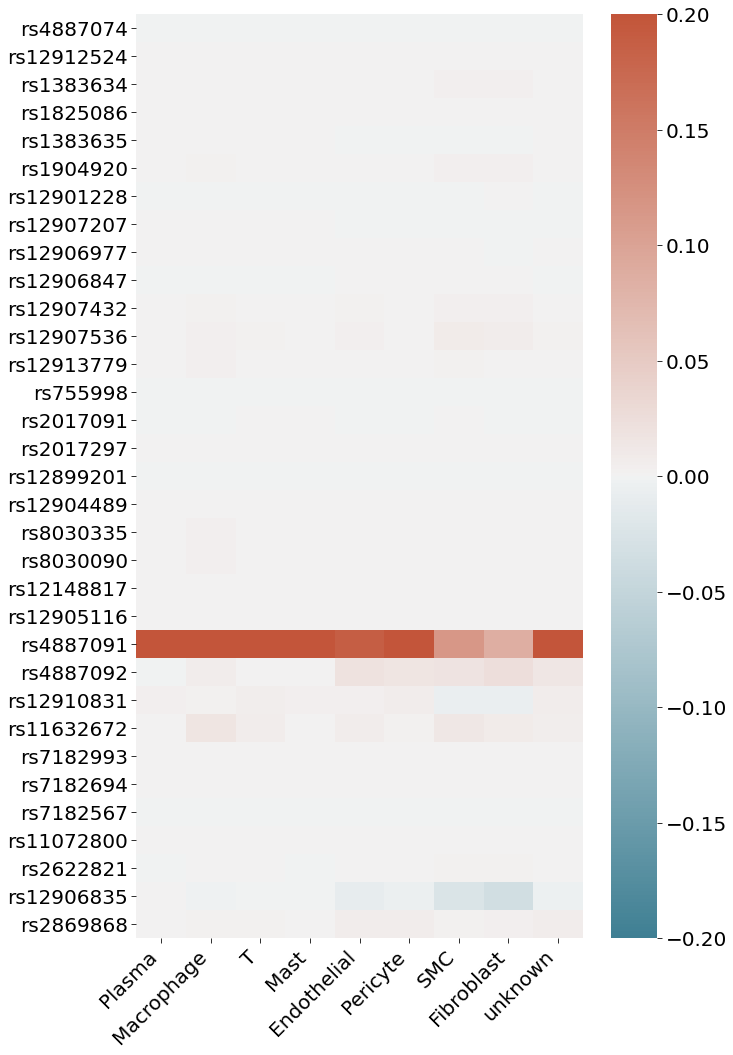

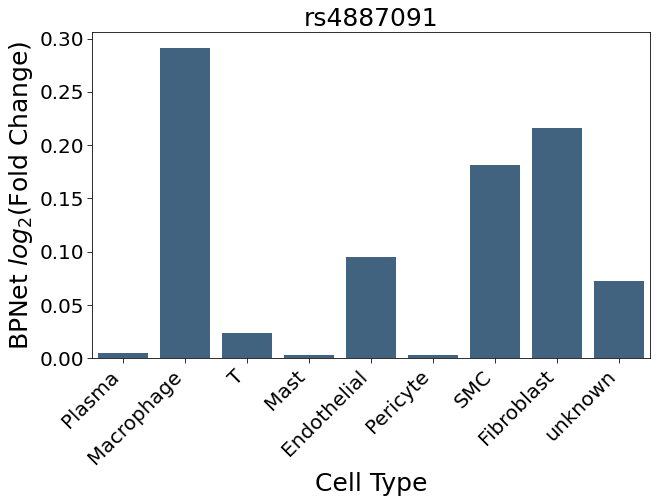

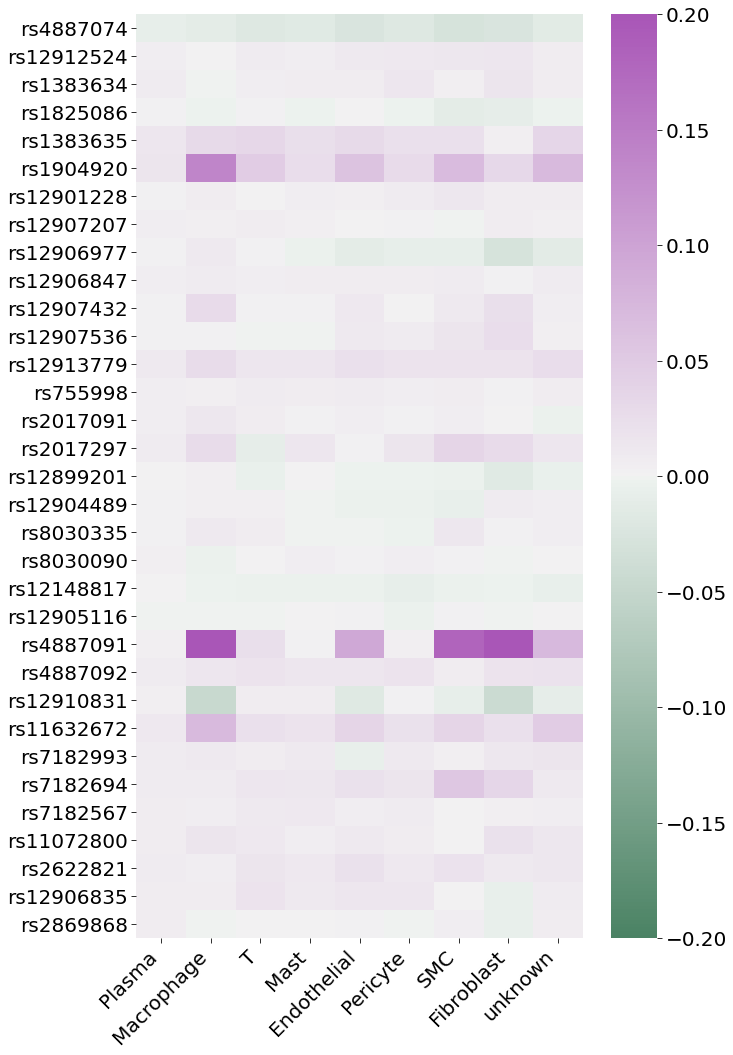

################################################
####### Causal variant: rs17374036 ########
################################################


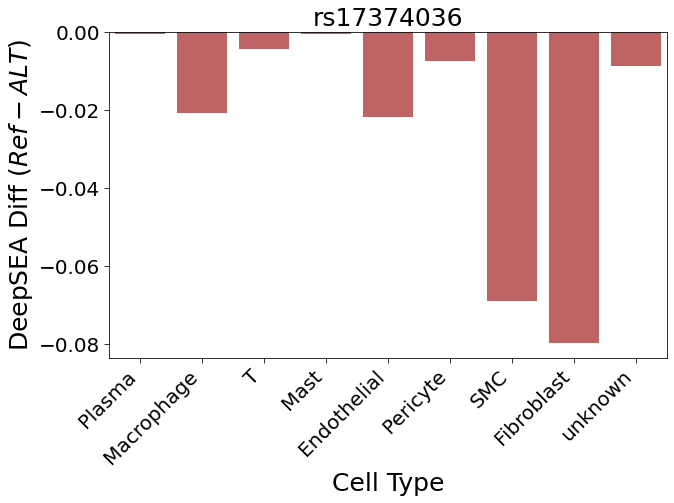

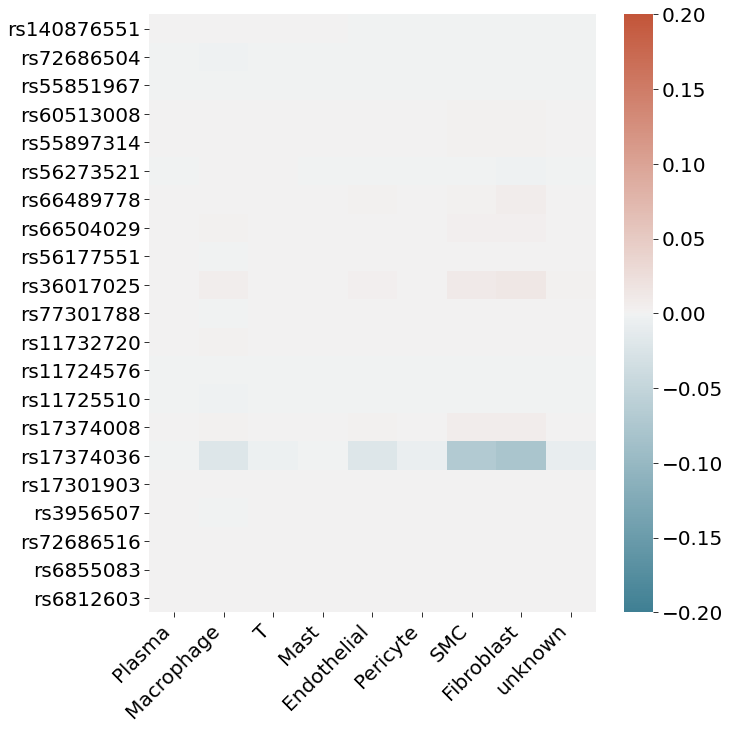

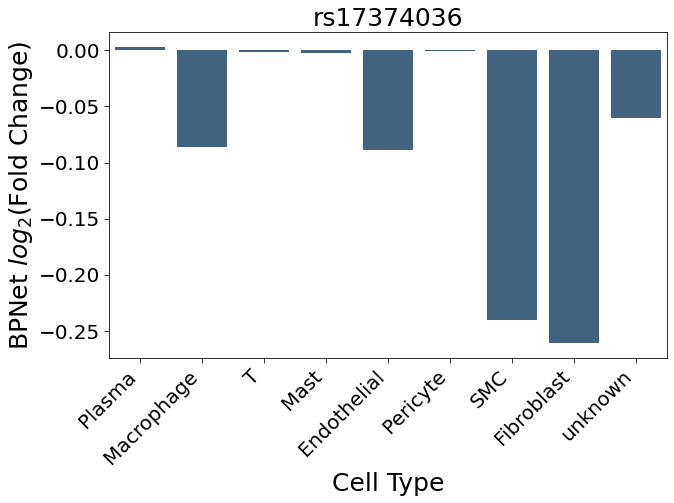

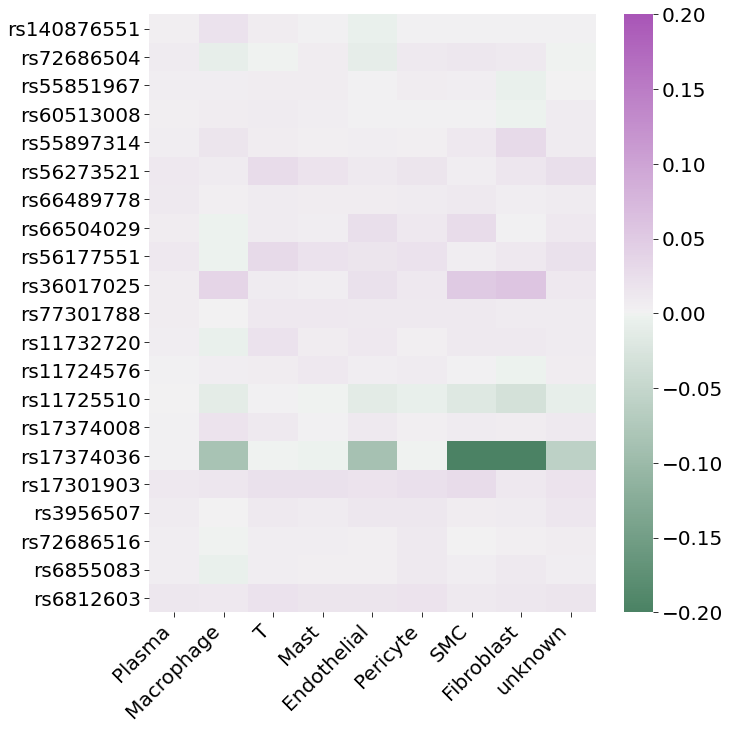

################################################
####### Causal variant: rs56155140 ########
################################################


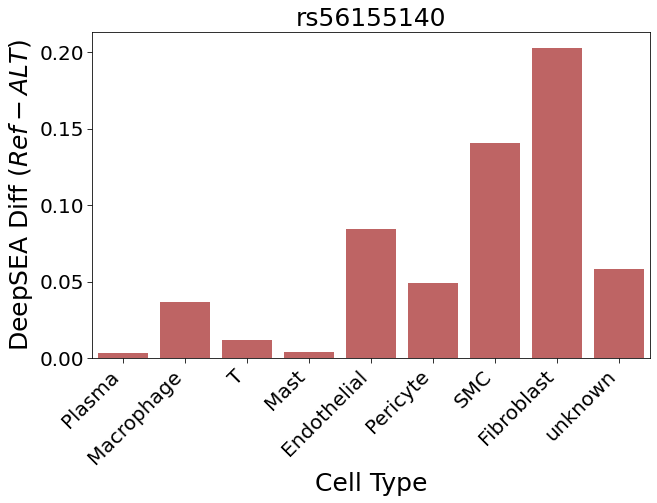

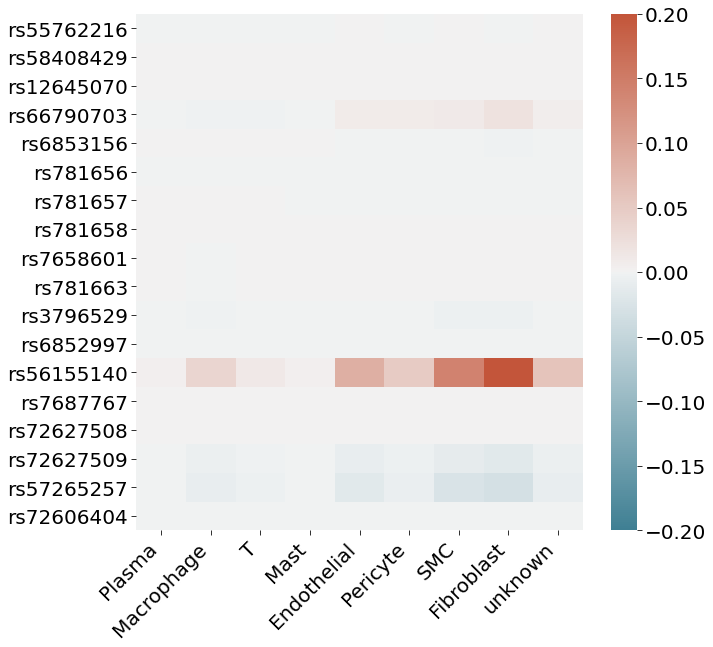

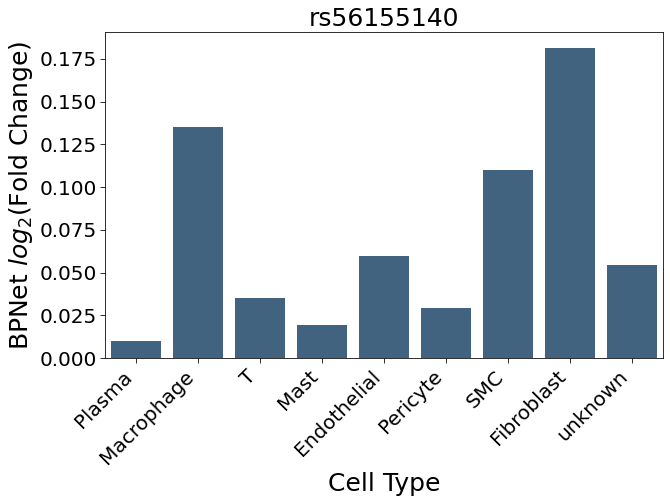

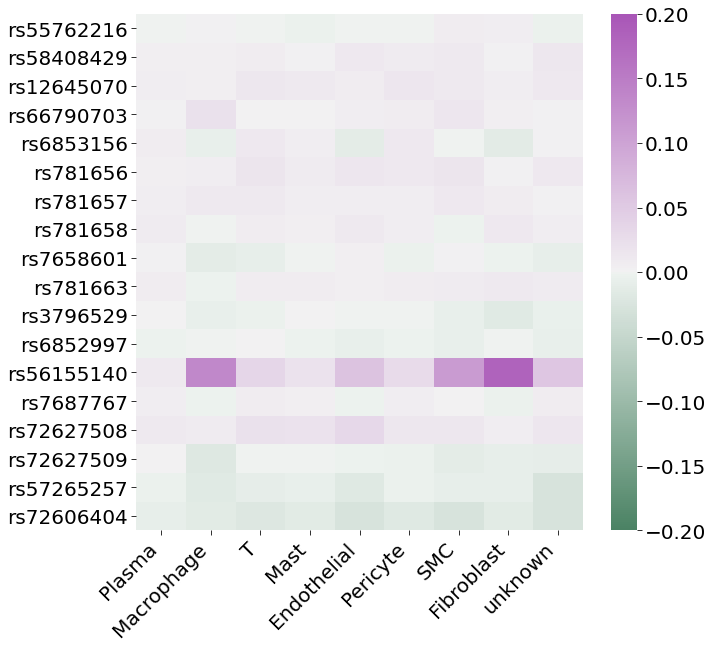

In [137]:
for causal_variant in potentially_relevant_snps:
    ld_variants_df = pd.read_csv(f"./ld_variants/{causal_variant}.tsv", sep='\t')
    ld_variants_df = ld_variants_df[ld_variants_df['R2'] > 0.8]
    non_causal_variant = list(set(ld_variants_df['RS_Number']).intersection(set(deepsea_df['name'])))
    
    print("################################################")
    print(f"####### Causal variant: {causal_variant} ########")
    print("################################################")
#     df = make_locuszoom_plot_and_get_other_variants(causal_variant)
    
    make_barplots_and_heatmaps(causal_variant, non_causal_variant)

## Get nearest gene

In [138]:
gtf = "/scratch/dyl3pc/fastqtl/data/original_data/gencode.v32.genes.ERCC.gtf"
columns = ["chr", "source", "type", "start", "end", "score", "strand", "frame", "additional_info"]
gtf = pd.read_csv(gtf, comment = "#", sep = "\t",
                names = columns)
gtf = gtf[gtf["type"] == "gene"]
gtf.drop(columns = ["type"], axis = 1, inplace = True)
def get_attribute(e, attribute):
    i = e.find(attribute)
    e = e[i + len(attribute) + 2:]
    i = e.find(";")
    return e[:i - 1]

# load the gtf
gtf["gene_name"] = gtf["additional_info"].apply(get_attribute, args = ["gene_name"])
gtf["gene_id"] = gtf["additional_info"].apply(get_attribute, args = ["gene_id"])
gtf["transcript_type"] = gtf["additional_info"].apply(get_attribute, args = ["transcript_type"])
gtf = gtf[gtf['transcript_type'] == 'protein_coding']

In [171]:
def get_nearest_gene(rsid):
    pos = utils.get_rsid_pos(rsid)
    chr_ = utils.get_rsid_chr(rsid)
    gene_gtf = gtf[gtf['chr'] == f"chr{chr_}"]
    gene_gtf['col1'] = gene_gtf['start']-pos
    gene_gtf['col2'] = gene_gtf['end']-pos
    all_distances = list(gene_gtf['col1']) + list(gene_gtf['col2'])
    upstream_distances = min([e for e in all_distances if e>0])
    downstream_distances = max([e for e in all_distances if e<0])
    gene_gtf_upstream = gene_gtf[(gene_gtf['col1']==upstream_distances) | (gene_gtf['col2']==upstream_distances)]
    upstream_gene = gene_gtf_upstream.iloc[0]['gene_name']

    gene_gtf_downstream = gene_gtf[(gene_gtf['col1']==downstream_distances) | (gene_gtf['col2']==downstream_distances)]
    downstream_gene = gene_gtf_downstream.iloc[0]['gene_name']

    return (upstream_gene, downstream_gene)

In [172]:
for causal_snp in potentially_relevant_snps:
    print(causal_snp)
    print(get_nearest_gene(causal_snp))

rs1958320
('HHIPL1', 'HHIPL1')
rs17293632
('SMAD3', 'SMAD3')
rs4887091
('ADAMTS7', 'CHRNB4')
rs17374036
('MAD2L1', 'PDE5A')
rs56155140
('NOA1', 'REST')


<ipython-input-171-ae8486d5dda4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_gtf['col1'] = gene_gtf['start']-pos
<ipython-input-171-ae8486d5dda4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_gtf['col2'] = gene_gtf['end']-pos
<ipython-input-171-ae8486d5dda4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

# Comparing Different Folds

In [5]:
deepsea_df1 = df = pd.read_csv("/project/cphg-millerlab/CAD_QTL/coronary_QTL/epigenome/scATAC/deepsea/CAD_diffs.tsv", sep='\t')
deepsea_df2 = pd.read_csv("/project/cphg-millerlab/CAD_QTL/coronary_QTL/epigenome/scATAC/deepsea/different_training_splits/CAD_diffs.tsv", sep='\t')

In [6]:
deepsea1_scores_l = []
deepsea2_scores_l = []
celltype_l = []
rsid_l = []
for rsid in deepsea_df['name']:
    deepsea_rsid_df1 = deepsea_df1[deepsea_df1['name'] == rsid]
    deepsea_rsid_df2 = deepsea_df2[deepsea_df2['name'] == rsid]
    for ctype in cell_types:
        deepsea1_scores_l.append(deepsea_rsid_df1.iloc[0][ctype])
        deepsea2_scores_l.append(deepsea_rsid_df2.iloc[0][ctype])
        celltype_l.append(ctype)
        rsid_l.append(rsid)
df = pd.DataFrame({'rsid':rsid_l, 'cell_type':celltype_l, 'deepsea_diff_1': deepsea1_scores_l, 'deepsea_diff_2': deepsea2_scores_l})

(-0.5, 0.5)

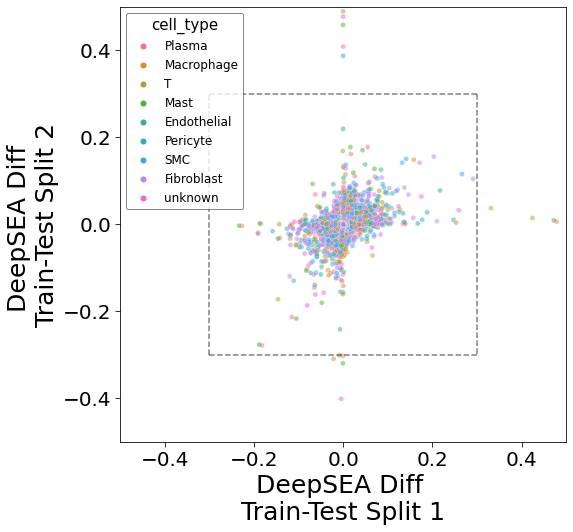

In [10]:
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.loc'] = "upper left"

sns.scatterplot(data=df, x="deepsea_diff_1", y="deepsea_diff_2", alpha=0.5, hue="cell_type", palette=cell_type_palette)
plt.xlabel("DeepSEA Diff \nTrain-Test Split 1")
plt.ylabel("DeepSEA Diff \nTrain-Test Split 2")

plt.plot([-0.3,-0.3], [-0.3, 0.3], 'k--', markeredgewidth=0.5, alpha=0.5)
plt.plot([-0.3, 0.3], [0.3, 0.3], 'k--', markeredgewidth=0.5, alpha=0.5)
plt.plot([0.3, 0.3], [0.3, -0.3], 'k--', markeredgewidth=0.5, alpha=0.5)
plt.plot([0.3, -0.3], [-0.3, -0.3], 'k--', markeredgewidth=0.5, alpha=0.5)
plt.xlim([-0.5, 0.5])
plt.ylim([-0.5, 0.5])

rs17293632
rs12972266
rs56170783
rs56155140


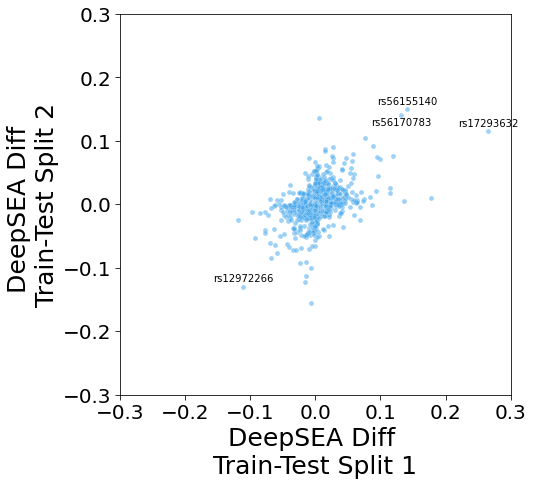

In [8]:
plt.rcParams["figure.figsize"] = (7,7)


data = df[df['cell_type']=="SMC"]
sns.scatterplot(data=data, x="deepsea_diff_1", y="deepsea_diff_2", alpha=0.5, color=cell_type_palette['SMC'])
plt.xlabel("DeepSEA Diff \nTrain-Test Split 1")
plt.ylabel("DeepSEA Diff \nTrain-Test Split 2")

plt.xlim([-0.3, 0.3])
plt.ylim([-0.3, 0.3])

for x,y,label in zip(data['deepsea_diff_1'], data['deepsea_diff_2'], data['rsid']):

    if abs(x)>=np.quantile(abs(data['deepsea_diff_1']), 0.999) and abs(y) >=np.quantile(abs(data['deepsea_diff_2']), 0.999):
        offset = (0,5)
        ha = 'center'
        print(label)
        if label == 'rs1958320':
            ha = "right"
            offset = (0,-10)
        elif label == "rs56170783":
            offset = (0,-10)
        plt.annotate(label, # this is the text
                     (x,y), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=offset, # distance from text to points (x,y)
                     ha=ha) # horizontal alignment can be left, right or center

plt.show()

rs1958320
rs17293632
rs4887091
rs17374036
rs56155140


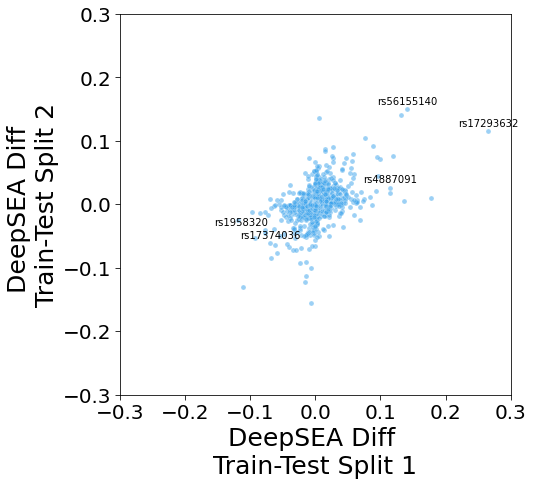

In [9]:
previous_causal_snps = """
rs1958320
rs17293632
rs4887091
rs17374036
rs56155140
""".strip().split()

plt.rcParams["figure.figsize"] = (7,7)


data = df[df['cell_type']=="SMC"]
sns.scatterplot(data=data, x="deepsea_diff_1", y="deepsea_diff_2", alpha=0.5, color=cell_type_palette['SMC'])
plt.xlabel("DeepSEA Diff \nTrain-Test Split 1")
plt.ylabel("DeepSEA Diff \nTrain-Test Split 2")

plt.xlim([-0.3, 0.3])
plt.ylim([-0.3, 0.3])

for x,y,label in zip(data['deepsea_diff_1'], data['deepsea_diff_2'], data['rsid']):

    if label in previous_causal_snps:
        offset = (0,5)
        ha = 'center'
        print(label)
        if label == 'rs1958320':
            ha = "right"
            offset = (0,-10)
        elif label == "rs56170783":
            offset = (0,-10)
        plt.annotate(label, # this is the text
                     (x,y), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=offset, # distance from text to points (x,y)
                     ha=ha) # horizontal alignment can be left, right or center
        

plt.show()